In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [107]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train = datasets.MNIST('../data/MNIST/train', train=True, download=True, transform=mnist_transform)
test = datasets.MNIST('../data/MNIST/test', train=False, download=True, transform=mnist_transform)

trainset = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

In [104]:
class Net(nn.Module):
    
    class Coder(nn.Module):
        def __init__(self, num_layers=1, neurons=64, activation=torch.sigmoid, init=False, latent_size=10):
            super().__init__()

            self.layers = nn.ModuleList()
            self.activation = activation

            if not isinstance(neurons, list):
                neurons = [neurons] * num_layers

            if activation == torch.relu:
                self.init_fn = nn.init.kaiming_uniform_
            else:
                self.init_fn = nn.init.xavier_uniform_

            for i in range(num_layers):
                layer = nn.Linear(neurons[i], neurons[i])
                if init:
                    self.init_fn(layer.weight)
                self.layers.append(layer)
                
        def forward(self, x):
            for layer in self.layers[:-1]:
                x = self.activation(layer(x))

            return F.tanh(self.layers[-1](x))

    class Encoder(Coder):
        def __init__(self, num_layers=1, neurons=64, activation=torch.sigmoid, init=False, latent_size=10):
            super().__init__()

            self.layers[0].in_features = 28*28
            self.layers[-1].out_features = latent_size
            if init:
                nn.init.xavier_uniform_(self.layers[-1].weight)
            
    class Decoder(Coder):
        def __init__(self, num_layers=1, neurons=64, activation=torch.sigmoid, init=False, latent_size=10):
            super().__init__()
            
            self.layers[0].in_features = latent_size
            self.layers[-1].out_features = 28*28
            
            if init:
                nn.init.xavier_uniform_(self.layers[0].weight)
    
    def __init__(self, num_layers=1, neurons=64, activation=torch.sigmoid, init=False, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super().__init__()
        self.latent_size = latent_size
        self.E = self.Encoder(num_layers=num_layers, neurons=neurons, activation=activation, init=init, latent_size=latent_size)
        self.D = self.Decoder(num_layers=num_layers, neurons=neurons, activation=activation, init=init, latent_size=latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x.cuda(), target.cuda(), **kwargs)
        return self._loss

In [139]:
class Net_1l(nn.Module):
    
    class Encoder(nn.Module):
        def __init__(self, activation=F.sigmoid, batchnorm = False, latent_size=10):
            super().__init__()
            self.fc1 = nn.Linear(28*28, latent_size)
            self.bn1 = nn.BatchNorm1d(latent_size)
            self.activation = activation
            self.batchnorm = batchnorm

        def forward(self, x):
            x = self.fc1(x)
            if self.batchnorm:
                x = self.bn1(x)
            x = self.activation(x)
            return x

    class Decoder(nn.Module):
        def __init__(self, batchnorm=False, latent_size=10):
            super().__init__()
            self.fc1 = nn.Linear(latent_size, 28*28)
            self.bn1 = nn.BatchNorm1d(28*28)
            self.batchnorm = batchnorm

        def forward(self, x):
            x = self.fc1(x)
            if self.batchnorm:
                x = self.bn1(x)
            x = torch.tanh(x)
            return x
    
    def __init__(self, activation=F.sigmoid, batchnorm = False, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super().__init__()
        self.latent_size = latent_size
        self.E = self.Encoder(activation=activation, batchnorm=batchnorm, latent_size=latent_size)
        self.D = self.Decoder(batchnorm=batchnorm, latent_size=latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x.cuda(), target.cuda(), **kwargs)
        return self._loss

In [147]:
class Net_2l(nn.Module):
    
    class Encoder(nn.Module):
        def __init__(self, activation=F.sigmoid, batchnorm=False, latent_size=10):
            super().__init__()
            self.fc1 = nn.Linear(28*28, 128)
            self.bn1 = nn.BatchNorm1d(128)
            self.fc2 = nn.Linear(128, latent_size)
            self.bn2 = nn.BatchNorm1d(latent_size)
            
            self.batchnorm = batchnorm
            self.activation = activation

        def forward(self, x):
            x = self.fc1(x)
            if self.batchnorm:
                x = self.bn1(x)            
            x = self.activation(x)
            
            x = self.fc2(x)
            if self.batchnorm:
                x = self.bn2(x)
            x = F.tanh(x)
            
            return x
    
    class Decoder(nn.Module):
        def __init__(self, activation=F.sigmoid, batchnorm=False, latent_size=10):
            super().__init__()
            self.fc1 = nn.Linear(latent_size, 128)
            self.bn1 = nn.BatchNorm1d(128)
            self.fc2 = nn.Linear(128, 28*28)
            self.bn2 = nn.BatchNorm1d(28*28)

            self.batchnorm = batchnorm
            self.activation = activation

        def forward(self, x):
            x = self.fc1(x)
            if self.batchnorm:
                x = self.bn1(x)
            x = self.activation(x)

            x = self.fc2(x)
            if self.batchnorm:
                x = self.bn2(x)
            x = F.tanh(x)
            return x
    
    def __init__(self, activation=F.sigmoid, batchnorm=False, latent_size=10, loss=F.mse_loss, lr=1e-4, l2=0.):
        super().__init__()
        self.latent_size = latent_size
        self.E = self.Encoder(activation=activation, batchnorm=batchnorm, latent_size=latent_size)
        self.D = self.Decoder(activation=activation, batchnorm=batchnorm, latent_size=latent_size)
        self.loss_fn = loss
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
        
    def encode(self, x):
        with torch.no_grad():
            return self.E(x)
        
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [148]:
latent_size = 10

models = [
    Net_1l(activation=F.sigmoid, latent_size=latent_size).cuda(),
    Net_1l(activation=F.sigmoid, batchnorm=True, latent_size=latent_size).cuda(),
    Net_1l(activation=F.relu, latent_size=latent_size).cuda(),
    Net_1l(activation=F.relu, batchnorm=True, latent_size=latent_size).cuda(),
    Net_2l(activation=F.sigmoid, latent_size=latent_size).cuda(),
    Net_2l(activation=F.sigmoid, batchnorm=True, latent_size=latent_size).cuda(),
    Net_2l(activation=F.relu, latent_size=latent_size).cuda(),
    Net_2l(activation=F.relu, batchnorm=True, latent_size=latent_size).cuda()
]
loss_test = []
epochs = 100
i = 0
loss__ = []

for e in range(epochs):
    loss_ = []
    for model in models:
        for data, _ in trainset:
            model.optim.zero_grad()
            output = model(data.cuda())
            loss = model.loss(data.view(-1, 28*28).cuda(), output.cuda())
            loss.backward()
            model.optim.step()

        for test_data, _ in testset:
            with torch.no_grad():
                output = model(test_data.cuda())
                loss = model.loss(test_data.view(-1, 28*28).cuda(), output.cuda())
        else:
            loss_.append(loss)
      
    loss__.append(loss_)
    print("epoch %d. Losses: %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f" % (e+1, *loss_))

epoch 1. Losses: 0.687 1.060 0.680 0.957 0.268 0.772 0.284 0.765
epoch 2. Losses: 0.402 0.980 0.348 1.125 0.254 0.681 0.198 0.617
epoch 3. Losses: 0.333 0.885 0.275 0.732 0.240 0.622 0.148 0.666
epoch 4. Losses: 0.318 0.802 0.256 0.987 0.266 0.625 0.177 0.610
epoch 5. Losses: 0.296 0.832 0.250 0.730 0.193 0.634 0.142 0.793
epoch 6. Losses: 0.272 0.681 0.255 0.570 0.184 0.567 0.143 0.485
epoch 7. Losses: 0.242 0.612 0.237 0.545 0.178 0.865 0.126 0.483
epoch 8. Losses: 0.254 0.550 0.191 1.020 0.168 0.859 0.133 0.442
epoch 9. Losses: 0.232 0.567 0.216 0.869 0.175 0.684 0.102 0.521
epoch 10. Losses: 0.219 0.563 0.240 0.600 0.152 0.706 0.089 0.559
epoch 11. Losses: 0.207 0.557 0.248 0.977 0.153 0.718 0.114 0.648
epoch 12. Losses: 0.221 0.584 0.181 0.832 0.131 0.541 0.084 0.458
epoch 13. Losses: 0.222 0.603 0.208 0.447 0.156 0.682 0.102 0.572
epoch 14. Losses: 0.195 0.687 0.181 0.770 0.139 0.691 0.093 0.401
epoch 15. Losses: 0.221 0.407 0.197 0.451 0.132 0.613 0.100 0.578
epoch 16. Losses: 0

KeyboardInterrupt: 

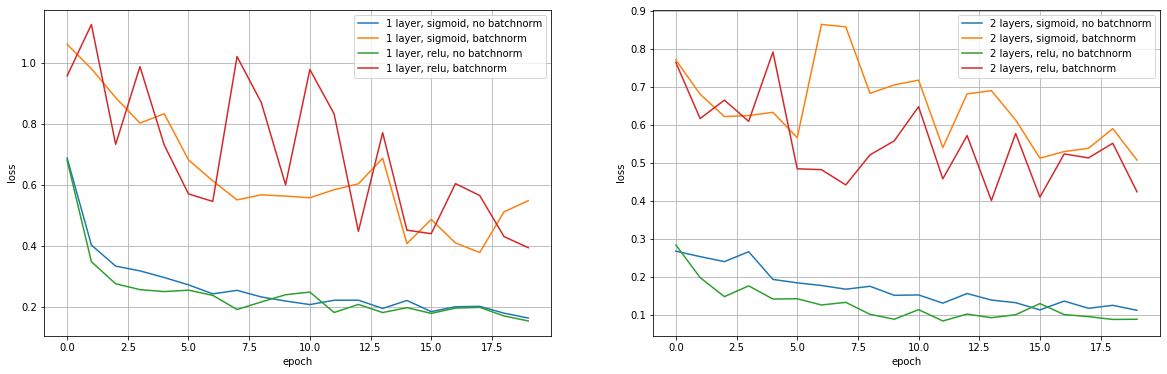

In [149]:
f = plt.figure(figsize=(20, 6))

ax0 = f.add_subplot(121)
plt.plot(np.array(loss__)[:, 0], label='1 layer, sigmoid, no batchnorm')
plt.plot(np.array(loss__)[:, 1], label='1 layer, sigmoid, batchnorm')
plt.plot(np.array(loss__)[:, 2], label='1 layer, relu, no batchnorm')
plt.plot(np.array(loss__)[:, 3], label='1 layer, relu, batchnorm')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

ax0 = f.add_subplot(122)
plt.plot(np.array(loss__)[:, 4], label='2 layers, sigmoid, no batchnorm')
plt.plot(np.array(loss__)[:, 5], label='2 layers, sigmoid, batchnorm')
plt.plot(np.array(loss__)[:, 6], label='2 layers, relu, no batchnorm')
plt.plot(np.array(loss__)[:, 7], label='2 layers, relu, batchnorm')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [115]:
loss__[-1]

[tensor(0.1189, device='cuda:0'),
 tensor(0.1161, device='cuda:0'),
 tensor(0.0976, device='cuda:0'),
 tensor(0.1182, device='cuda:0'),
 tensor(0.1226, device='cuda:0'),
 tensor(0.0734, device='cuda:0'),
 tensor(0.0748, device='cuda:0'),
 tensor(0.0539, device='cuda:0')]

In [116]:
data, labels = next(iter(testset))

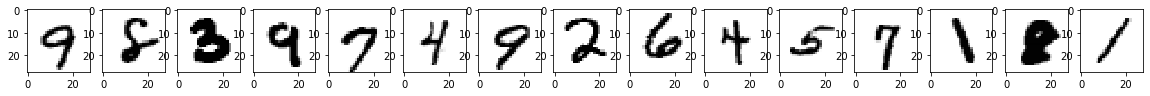

In [118]:
f = plt.figure(figsize=(20, 32))
ncols = 15

for i, img in enumerate(data[:15]):
    ax = f.add_subplot(np.ceil(len(data)/ncols), ncols, i+1)
    plt.imshow(img.view(28, 28).detach().numpy(), cmap = matplotlib.cm.binary)

In [119]:
data = models[-3](data.cuda()).cpu().view(-1, 1, 28, 28)

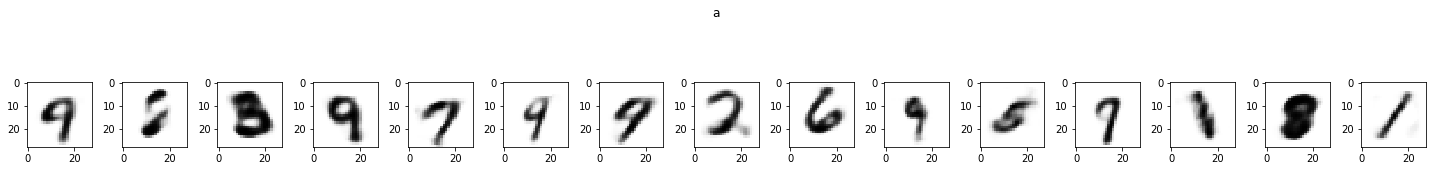

In [131]:
f = plt.figure(figsize=(20, 40))
f.suptitle('a')
ncols = 15

for i, img in enumerate(data[:15]):
    ax = f.add_subplot(np.ceil(len(data)/ncols), ncols, i+1)
    plt.imshow(img.view(28, 28).detach().numpy(), cmap = matplotlib.cm.binary)
    
plt.tight_layout()